

# Introduction
Customer attrition or customer churn occurs when customers or subscribers stop doing business with a company or service. Customer churn is a critical metric because it is much more cost effective to retain existing customers than it is to acquire new customers as it saves cost of sales and marketing. Customer retention is more cost-effective as you’ve already earned the trust and loyalty of existing customers.

There are various ways to calculate this metric as churn rate may represent the total number of customers lost, the percentage of customers lost compared to the company’s total customer count, the value of recurring business lost, or the percent of recurring value lost. However in this dataset, it is defined as a binary variable for each customer and calculating the rate is not the objective. The concept of the churn rate indicates there are factors which influence it and thus the objective here is to identify and quantify those factors.

I had come across this data analysis as part of an assignment for a online recruitment drive and it had to completed in 12 hours. Thus, it is a fairly easy and beginner level project with fewer variables. Since then I have decided to use a nueral network for prediction too.

## Contents

### 1. Exploratory Data Analysis: 
Only missing values found were in total charges column. I decided to drop those observations as they were very minute compared to the total observations. No features could be dropped owing to multi-collinearity as explained below the heatmap of collinearity. Only customer ID was dropped.
### 2. Modelling
#### 2.1 Machine Learning models
Several models were tested and tuning was done for Logistic Regression and Random Forest.
#### 2.2 Neural Networks
A basic neural network model is formed using pre-made linear and DNN classifiers and then using Keras Sequential models. Hyperparameter tuning for learning rate and number of layers is done. The performance is constant at 0.79 to 0.82 F1 score.
### 3. Performance of models
The performance of the model is demonstrated using confusion matrix and AUC ROC plots section. Random Forest gives a F1 score of 0.90 using stratified cross validation  Logistic Regression gives ROC score of 0.84 compared to 0.81 of Random Forest. Stratified cross validation is used as it gives more accurate and generalized score of the model and will predict better on unseen data than one set validation especially for imbalanced dataset.
The neural networks perform similarly to Logistic Regression. As seen in literature, neural networks are only useful for larger datasets.
### 4. Feature importance and Conclusion
The key factors or the important features are discussed in the Conclusion section. The key factors were Total Charges, tenure, monthly charges, and customer services such as tech support. The potential offers and implementation is discussed in detail in Conclusion section. 5 methods are discussed involving discounts on selected services.




In [1]:
import numpy as np
import pandas as pd
import datetime
import random

# Plots

import matplotlib.pyplot as plt
import seaborn as sns
# Models
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
import os
import tensorflow_datasets as tfds

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from matplotlib.ticker import MaxNLocator
pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df=pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


TotalCharges is an object type? Thus converting it into numeric.

In [5]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [6]:
calib=df[:4000]
calib.TotalCharges.isnull().sum()

7

Assuming there is no rule stating validation data values cannot be dropped, the 4 missing values are dropped.

In [7]:
df.dropna(inplace=True)

Customer ID is useless for modelling and prediction as it is just arbritary identification.

In [8]:
df.drop('customerID',1,inplace=True)

In [9]:
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

Some cols are binary and some cols have 3 unique values

In [10]:
uniq=df.nunique()
ord_cols=uniq[uniq==3].index
ord_cols

Index(['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract'],
      dtype='object')

In [11]:
for col in ord_cols:
    print(df[col].unique())

['No phone service' 'No' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['Month-to-month' 'One year' 'Two year']


Only Contract and Internet service have different unique values. The No interenet variable could be assigned to No as in some notebooks on Kaggle. However, dummy variables seems better encoding option instead as in former case there will be loss of data in which customer has chosen not to opt for a service despite having internet service. In case the number of features was larger, label encoding or mapping would be considered.

In [12]:
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)
df2=df
df2['SeniorCitizen'] = df2['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')
df1=pd.get_dummies(df)
df1.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


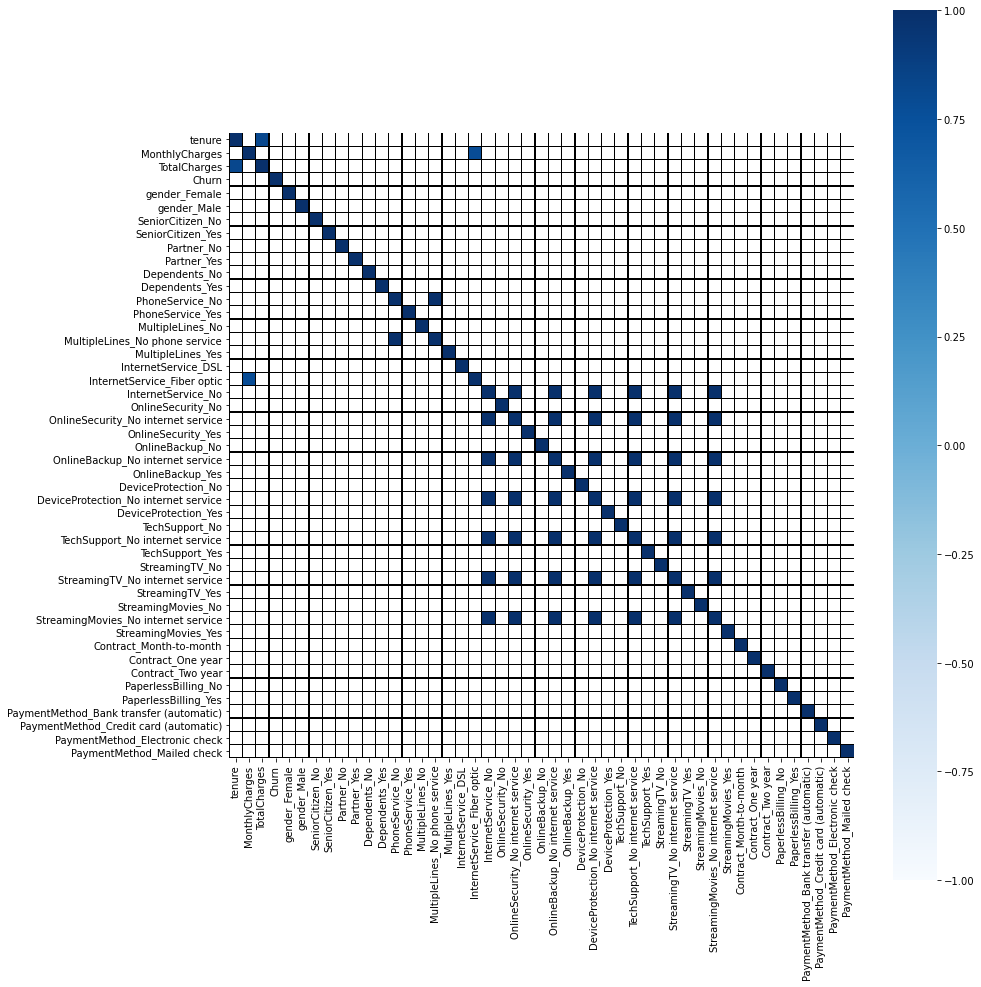

In [13]:
corre=df1.corr()
f, ax = plt.subplots(figsize=(14,16))
sns.heatmap(corre,mask=corre<0.75,linewidth=0.25,cmap="Blues",linecolor='Black', square=True)

Multi-Collinearity:
1. Monthly charges and Fiber optic: This indicates fiber optic internet is a costly service, hence a contributor to Churn.
2. Total Charges and Tenure: Naturally, the more years a customer has been subscribed to the service, the more the total charges.
3. No internet services and no phone services are correlated across different varibles.This can be used to form a seperate feature. However in the distributions it is observed that data points are few and thus it could make the matrix very sparse. If no internet/phone service in all features is denoted as 'No' it is a loss of data indicating the customer chose to opt out of the service despite having internet service.

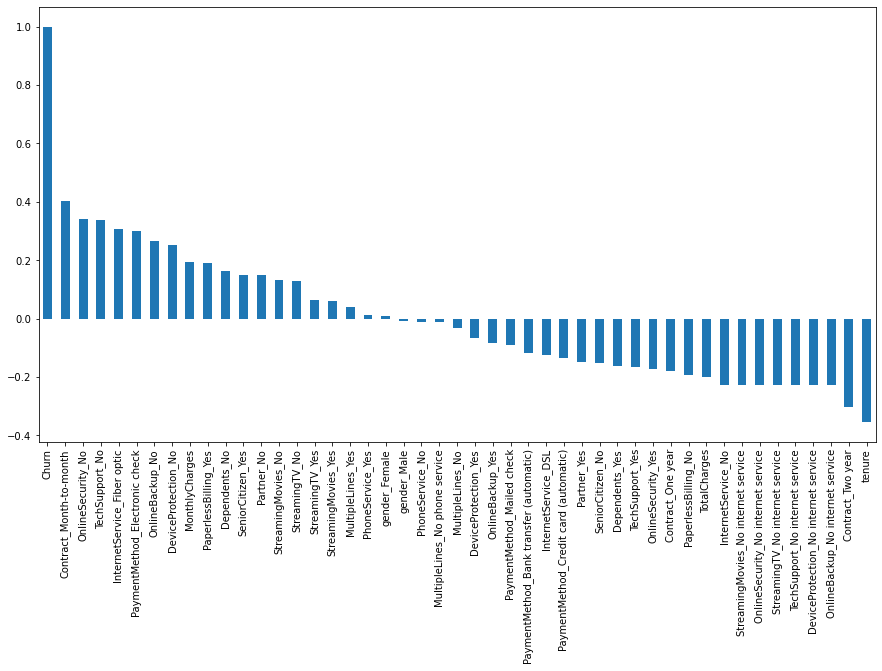

In [14]:
plt.figure(figsize=(15,8))
df1.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

In [15]:
df['gender'].value_counts()

Male      3549
Female    3483
Name: gender, dtype: int64

Thus, there is equal distribution of genders in the dataset and neither is correlated to churn

In [16]:
uniq=df.nunique()
cat_cols=uniq[uniq<5].index
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in df.columns:
    if df[i].dtype in numeric_dtypes:
        numeric.append(i)
numeric,cat_cols

(['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'],
 Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
        'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
       dtype='object'))

In [17]:
numeric=['tenure', 'MonthlyCharges', 'TotalCharges']
cat_feats=['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod']

# 1. Exploratory Data Analysis

It is important to check the distribution of these features provided in our data to check for biases if the feature values are impartially distributed.



In [18]:
def srt_dist(df=df,cols=cat_feats):
    fig, axes = plt.subplots(8, 2,squeeze=True)
    axes = axes.flatten()

    for i, j in zip(cols, axes):

        (df[i].value_counts()*100.0 /len(df)).plot.pie(autopct='%.1f%%',figsize =(10,37), fontsize =15,ax=j )                                                                      
        j.yaxis.label.set_size(15)

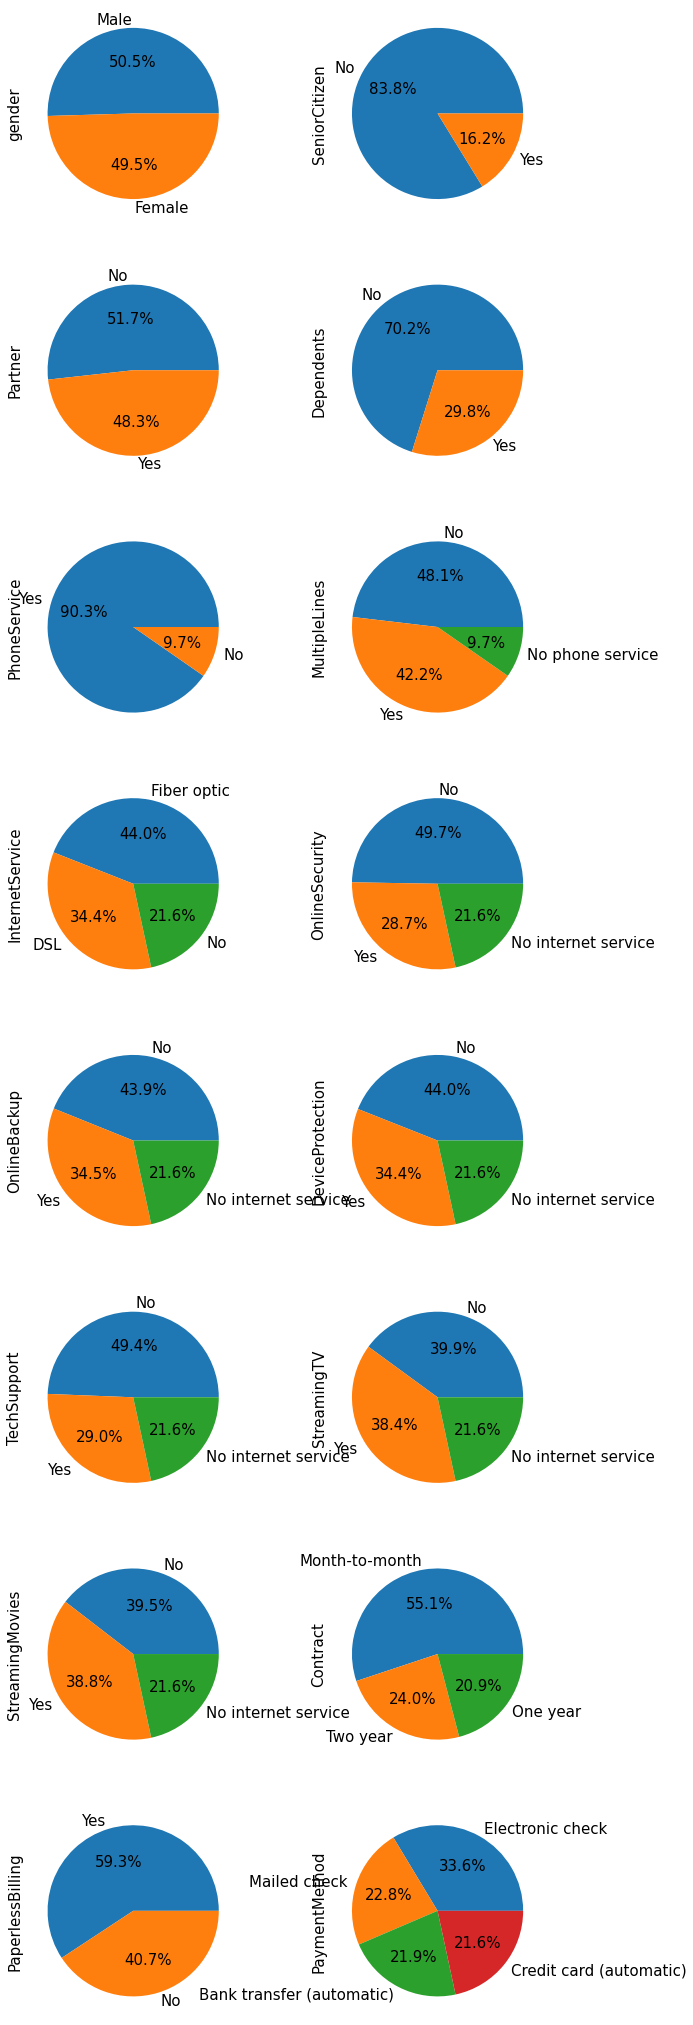

In [19]:
srt_dist()


Thus, it can be noted that most customers are young people, only 30% have dependents, and only 10% have no phone service.Thus, the correlations drawn from these variables can be doubted.

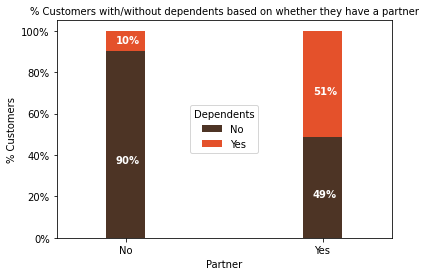

In [20]:
import matplotlib.ticker as mtick
colors = ['#4D3425','#E4512B']
partner_dependents = df.groupby(['Partner','Dependents']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (6,4),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':10},title = 'Dependents',fontsize =10)
ax.set_ylabel('% Customers',size = 10)
ax.set_title('% Customers with/without dependents based on whether they have a partner',size = 10)
ax.xaxis.label.set_size(10)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 10)

Thus, it coincides with intuition that more customers who do not have a partner also do not have dependents 

Text(0.5, 1.0, '# of Customers by their tenure')

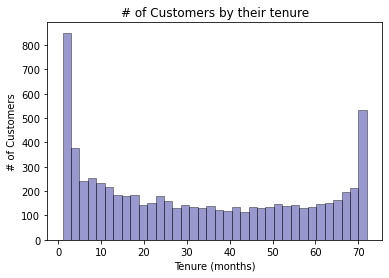

In [21]:
ax = sns.distplot(df['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('# of Customers by their tenure')

Text(0.5, 1.0, 'Two Year Contract')

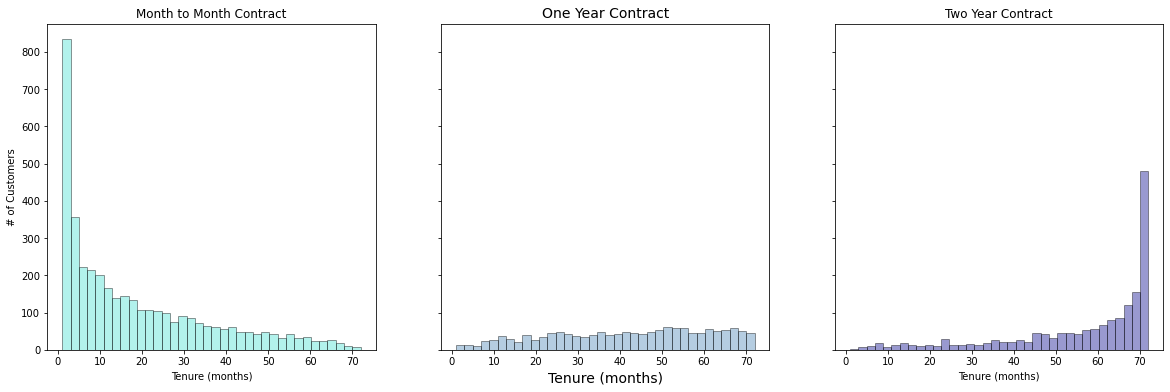

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(df[df['Contract']=='Month-to-month']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'turquoise',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Month to Month Contract')

ax = sns.distplot(df[df['Contract']=='One year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'steelblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('One Year Contract',size = 14)

ax = sns.distplot(df[df['Contract']=='Two year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'darkblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract')

Naturally, month to month contract customers tenure lower than customer with two year contracts.

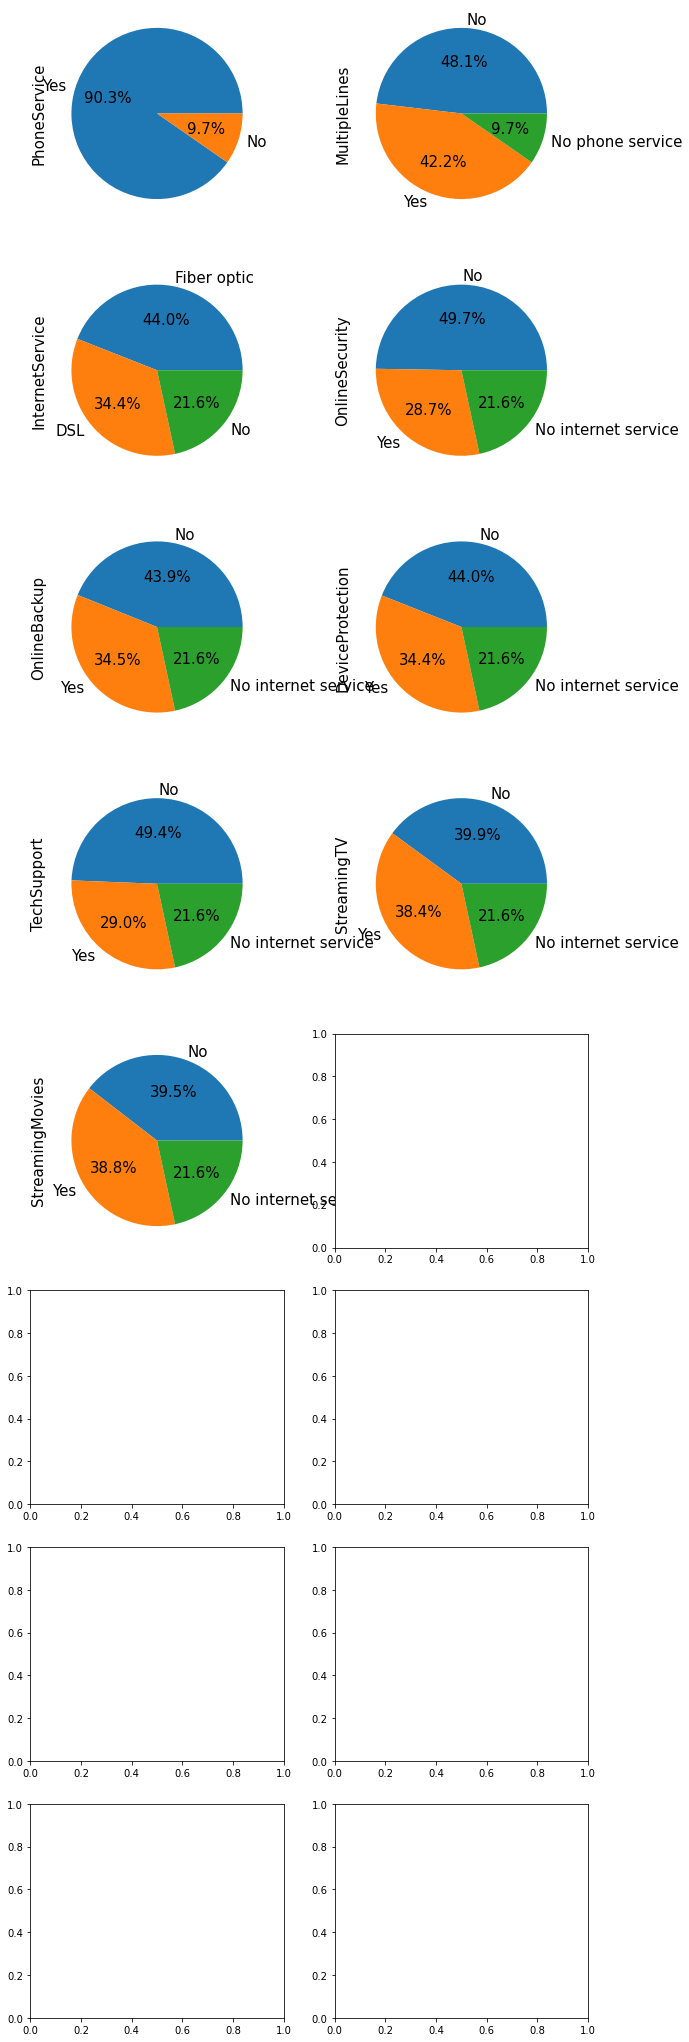

In [23]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

srt_dist(df,services)

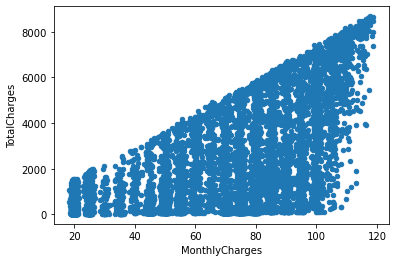

In [24]:
df[['MonthlyCharges', 'TotalCharges']].plot.scatter(x = 'MonthlyCharges',y='TotalCharges')

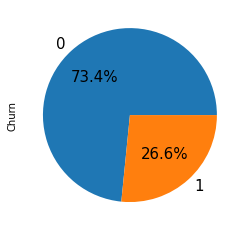

In [25]:
(df['Churn'].value_counts()*100.0 /len(df)).plot.pie(autopct='%.1f%%', fontsize =15)

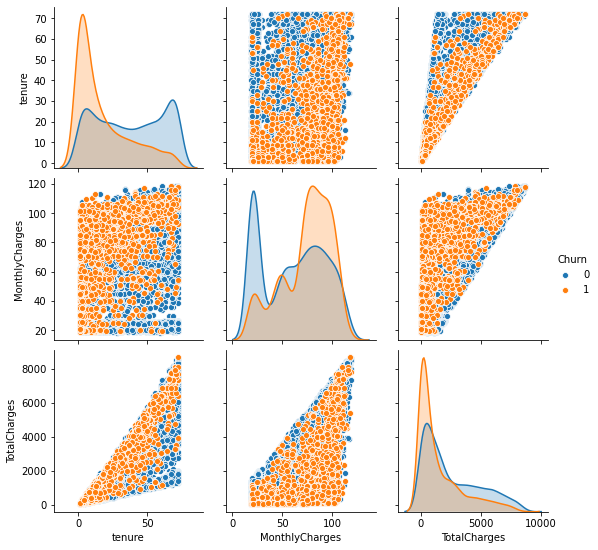

In [26]:
sns.pairplot(df,vars = ['tenure','MonthlyCharges','TotalCharges'], hue="Churn")

People having lower tenure and higher monthly charges are tend to churn more. Also as you can see below; having month-to-month contract and fiber obtic internet have a really huge effect on churn probability.

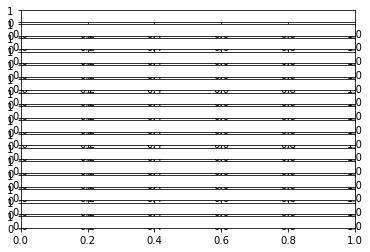

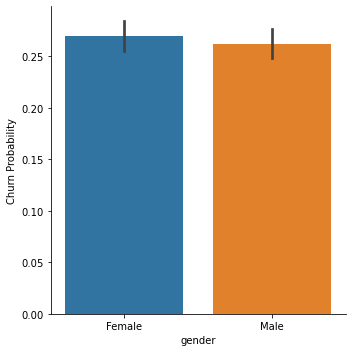

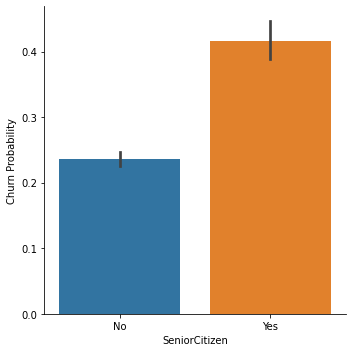

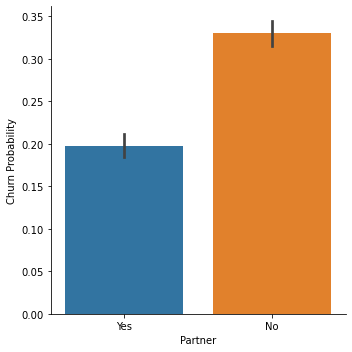

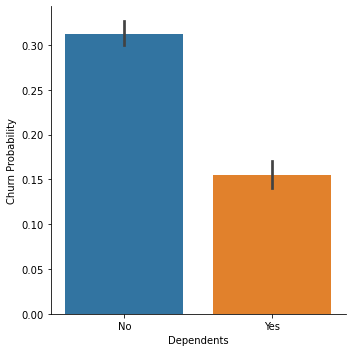

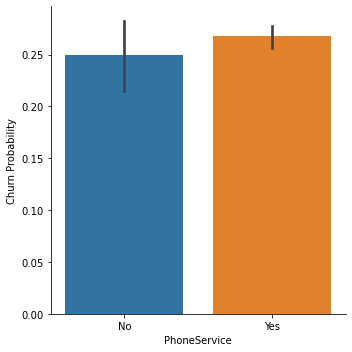

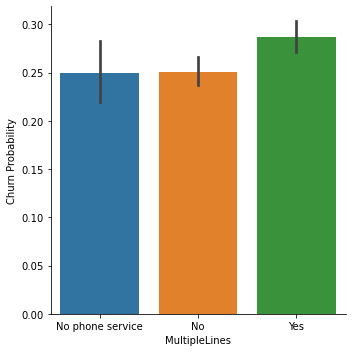

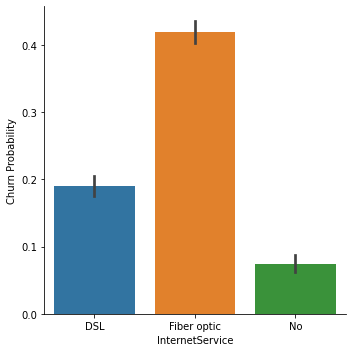

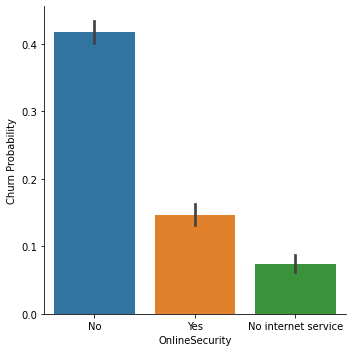

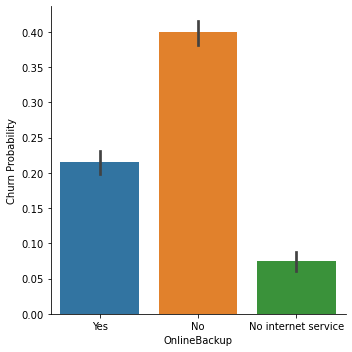

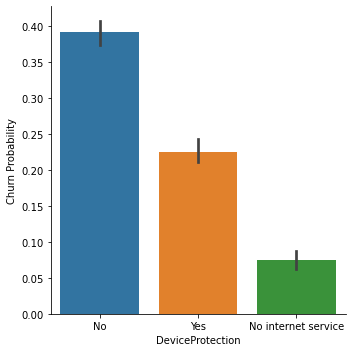

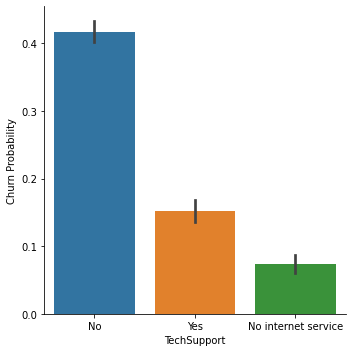

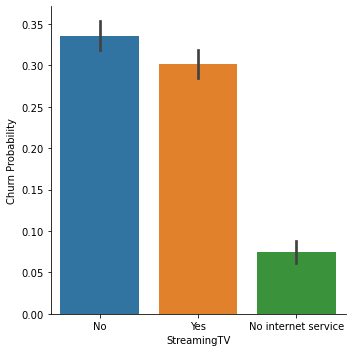

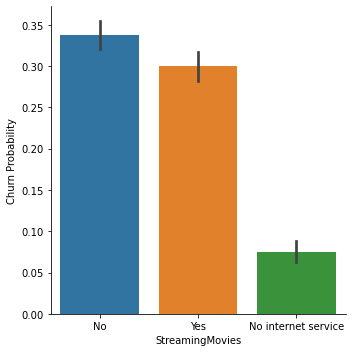

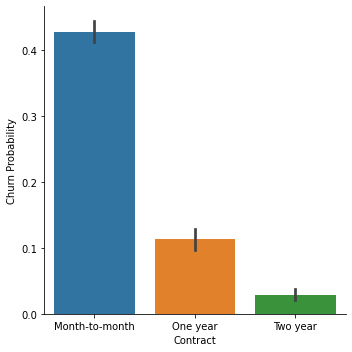

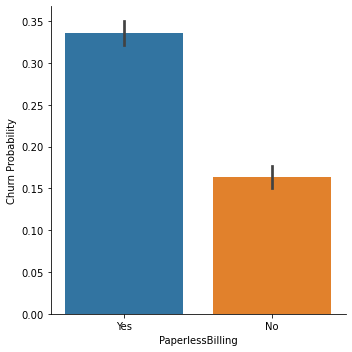

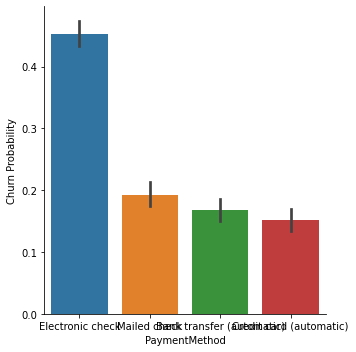

In [27]:
cat_feats=['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod']
fig,axes = plt.subplots(16)
axes = axes.flatten()

for i, j in zip(cat_feats, axes):

    sortd = df.groupby([i])['Churn'].median().sort_values(ascending=False)
    j=sns.catplot(x=i,
                y='Churn',
                data=df,
                kind='bar')
    j.set_ylabels("Churn Probability")

It is observed probability of churn is high for highly correlated features such as No partner or dependent, no tech support, month to month contract,etc.

# 2. Modelling

In [28]:
# Split and normalization
y=df1.Churn.values
X=df1.drop('Churn',1)
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features
y=df1['Churn']

In [29]:
X_train=X.iloc[:3993,:]
X_test=X.iloc[3993:,:]
y_train=df1.iloc[:3993,:]['Churn']
y_test=df1.iloc[3993:,:]['Churn']

We can use stratified CV which splits train and test data according to classes, it is useful for imbalanced categorical variables such as this dataset

In [30]:
def stratified_cv(X, y, clf_class, shuffle=True,  **kwargs):
    stratified_k_fold = StratifiedKFold().split(X,y)
    y_pred = y.copy()
    for ii, jj in stratified_k_fold: 
        Xtrain, Xtest = X.iloc[ii], X.iloc[jj]
        ytrain = y.iloc[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred.iloc[jj] = clf.predict(Xtest)
    return y_pred

### 2.1 Machine Learning Models

In [31]:
print('Gradient Boosting Classifier:  {:.2f}'.format(
    metrics.accuracy_score(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))

print('Support vector machine(SVM):   {:.2f}'.format(
    metrics.accuracy_score(y, stratified_cv(X, y, svm.SVC))))

print('Random Forest Classifier:      {:.2f}'.format(
    metrics.accuracy_score(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))

print('K Nearest Neighbor Classifier: {:.2f}'.format(
    metrics.accuracy_score(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))

print('Logistic Regression:           {:.2f}'.format(
    metrics.accuracy_score(y, stratified_cv(X, y, linear_model.LogisticRegression))))
print('XGBoost Classifier:           {:.2f}'.format(
    metrics.accuracy_score(y, stratified_cv(X, y, XGBClassifier))))

Gradient Boosting Classifier:  0.82
Support vector machine(SVM):   0.81
Random Forest Classifier:      0.91
K Nearest Neighbor Classifier: 0.81
Logistic Regression:           0.80
XGBoost Classifier:           0.89


In [32]:
print('Gradient Boosting Classifier:\n {}\n'.format(
    metrics.classification_report(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))

print('Support vector machine(SVM):\n {}\n'.format(
    metrics.classification_report(y, stratified_cv(X, y, svm.SVC))))

print('Random Forest Classifier:\n {}\n'.format(
    metrics.classification_report(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))

print('K Nearest Neighbor Classifier:\n {}\n'.format(
    metrics.classification_report(y, stratified_cv(X, y, neighbors.KNeighborsClassifier,n_neighbors=11))))

print('Logistic Regression:\n {}\n'.format(
    metrics.classification_report(y, stratified_cv(X, y, linear_model.LogisticRegression))))
      
print('XGBoost Classifier:\n {}\n'.format(
    metrics.classification_report(y, stratified_cv(X, y, XGBClassifier))))

Gradient Boosting Classifier:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      5163
           1       0.71      0.58      0.64      1869

    accuracy                           0.82      7032
   macro avg       0.78      0.75      0.76      7032
weighted avg       0.82      0.82      0.82      7032


Support vector machine(SVM):
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      5163
           1       0.68      0.51      0.58      1869

    accuracy                           0.81      7032
   macro avg       0.76      0.71      0.73      7032
weighted avg       0.80      0.81      0.80      7032


Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      5163
           1       0.87      0.77      0.81      1869

    accuracy                           0.91      7032
   macro avg       0.89      0.86     

Thus, the random forest perfoms best owing to highest F1 scores. F1 scores is a function of precision and recall. XG Boost and GBM may also perform equally if hypertuned.

Higher the F1 score, lower the False Positive and False Negative rates.

### Hyperparameter Tuning 


In [34]:
# Tuning Random Forest
from sklearn.ensemble import RandomForestClassifier
# Create param grid.   
param_rf=[{'n_estimators' : list(range(10,150,15)),
            'max_features' : list(range(6,32,5))}]

# Create grid search object

clf = RandomizedSearchCV(RandomForestClassifier(), param_distributions = param_rf, n_iter=50, cv = 5, refit=True,verbose=1, n_jobs=-1,)

# Fit on data
best_clf = clf.fit(X, y)

print(best_clf.best_params_)
best_clf.best_score_


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.9min finished


{'n_estimators': 130, 'max_features': 6}


0.7896749740426096

In [35]:
# Tuning Logistic Regression
from sklearn.linear_model import LogisticRegression
param_grid = [
    {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-5, 5, 20),
    'solver' : ['liblinear'] }]
clf = RandomizedSearchCV(LogisticRegression(), param_distributions = param_grid, n_iter=20, cv = 5, refit=True,verbose=1, n_jobs=-1,)

# Fit on data

best_clf = clf.fit(X, y)
print(best_clf.best_params_)
best_clf.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   14.4s


{'solver': 'liblinear', 'penalty': 'l2', 'C': 8858.667904100832}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.2s finished


0.8043221203472578

# 2.2. Neural Network

For neural networks, both premade estimators and Keras Sequential models are used. I could not find documentation or references for hypertuning premade estimators, additionally most references I came across are on Convolutional Neural Networks and Image Classification.
The Keras models are hypertuned for learning rate and number of layers. The hyper parameter tuned model shows similar performance as the dataset is smaller than usual neural network applications.

1. Linear model Premade Estimator
2. DNNClassifier Premade Estimator
3. Keras Sequential model
4. Hypertuning with Keras

In [36]:
# Pre-made estimators inputs

import tensorflow_datasets as tfds
tfds.disable_progress_bar()
Xnn = df2.drop(['Churn'], axis=1)
ynn = df2['Churn']

from sklearn.model_selection import train_test_split as tts

X_tr,X_tes,Y_tr,Y_tes = tts(Xnn,ynn, test_size=0.2,random_state=42)

# feature extraction

tenure = tf.feature_column.numeric_column('tenure')
monthly_charges = tf.feature_column.numeric_column('MonthlyCharges')
total_charges = tf.feature_column.numeric_column('TotalCharges')
col_unique_val_counts = []
cat_columns = []
for col in Xnn.columns:
    if Xnn[col].dtype.name != 'object':
        continue
    unique_vals = Xnn[col].unique()
    col_unique_val_counts.append(len(unique_vals))
    cat_columns.append(col)
    print(col, "->",unique_vals)
cat_cols = [tf.feature_column.categorical_column_with_hash_bucket(col, hash_bucket_size=size) 
            for col, size in zip(cat_columns, col_unique_val_counts)]
num_cols = [tenure, monthly_charges, total_charges]
feature_columns = num_cols + cat_cols

gender -> ['Female' 'Male']
SeniorCitizen -> ['No' 'Yes']
Partner -> ['Yes' 'No']
Dependents -> ['No' 'Yes']
PhoneService -> ['No' 'Yes']
MultipleLines -> ['No phone service' 'No' 'Yes']
InternetService -> ['DSL' 'Fiber optic' 'No']
OnlineSecurity -> ['No' 'Yes' 'No internet service']
OnlineBackup -> ['Yes' 'No' 'No internet service']
DeviceProtection -> ['No' 'Yes' 'No internet service']
TechSupport -> ['No' 'Yes' 'No internet service']
StreamingTV -> ['No' 'Yes' 'No internet service']
StreamingMovies -> ['No' 'Yes' 'No internet service']
Contract -> ['Month-to-month' 'One year' 'Two year']
PaperlessBilling -> ['Yes' 'No']
PaymentMethod -> ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


Linear Classifier model of tensorflow

In [37]:

n_classes = 2 # churn Yes or No
batch_size = 128
import tensorflow_datasets as tfds

churn_file = tf.data.Dataset.from_tensor_slices((X,y))
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function
train_input_fn = make_input_fn(X_tr, Y_tr)
eval_input_fn = make_input_fn(X_tes,Y_tes, num_epochs=1, shuffle=False)

import tempfile
model_dir = tempfile.mkdtemp()
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=(X_tr.shape[0]/128)*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)
def get_callbacks(name):
    return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]
linear_model= tf.estimator.LinearClassifier(model_dir=model_dir,feature_columns=feature_columns, n_classes=n_classes,  
                                            optimizer=lambda:get_optimizer())
linear_model.train(input_fn=train_input_fn)
result = linear_model.evaluate(eval_input_fn)


print(result)


{'accuracy': 0.77683014, 'accuracy_baseline': 0.73418623, 'auc': 0.7907852, 'auc_precision_recall': 0.61979866, 'average_loss': 0.5508222, 'label/mean': 0.2658138, 'loss': 0.5506447, 'precision': 0.6630435, 'prediction/mean': 0.1800334, 'recall': 0.3262032, 'global_step': 1760}


In [38]:
# DNN Classifier (Deep Neural Network)
feature_cols1=[]
for col in Xnn.columns:
    if Xnn[col].dtype.name != 'object':
        continue
    unique_vals = Xnn[col].unique()
    col_unique_val_counts.append(len(unique_vals))
    cat_columns.append(col)
    cat_cols1 = tf.feature_column.categorical_column_with_vocabulary_list(col,unique_vals,num_oov_buckets=2)         
    catcols1_embedding = tf.feature_column.embedding_column(cat_cols1, dimension=4)                     
    feature_cols1.append(catcols1_embedding)
feature_cols=feature_cols1 + num_cols
feature_layer = tf.keras.layers.DenseFeatures(feature_cols1)

dnnmodel=tf.estimator.DNNClassifier(
    hidden_units=[128,54,8], feature_columns=feature_cols , n_classes=2,
    optimizer=lambda:get_optimizer(), activation_fn=tf.nn.relu,
    dropout=0.3 )
dnnmodel.train(input_fn=train_input_fn)
result = dnnmodel.evaluate(eval_input_fn)


print(result)


{'accuracy': 0.73418623, 'accuracy_baseline': 0.73418623, 'auc': 0.65820956, 'auc_precision_recall': 0.39783543, 'average_loss': 0.5572616, 'label/mean': 0.2658138, 'loss': 0.5571577, 'precision': 0.0, 'prediction/mean': 0.23725013, 'recall': 0.0, 'global_step': 1760}


## Keras model
A 64-8-1 dense layered model with a decaying learning rate of batch size 32 is used.

In [73]:
from keras.models import Sequential 
from keras.layers import InputLayer 
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.constraints import maxnorm

from  IPython import display

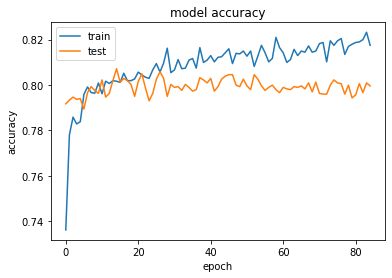

In [42]:
# Model 1
nn_model = Sequential()
nn_model.add(Dense(64,kernel_regularizer=tf.keras.regularizers.l2(0.001),
                input_dim=46, activation='relu' ))
nn_model.add(Dropout(rate=0.2))
nn_model.add(Dense(8,kernel_regularizer=tf.keras.regularizers.l2(0.001),
                    activation='relu'))
nn_model.add(Dropout(rate=0.1))
nn_model.add(Dense(1, activation='sigmoid'))
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001,
      decay_steps=(X_train.shape[0]/32)*50,
      decay_rate=1,
      staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)
def get_callbacks():
    return [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=70,restore_best_weights=True)]
nn_model.compile(loss = "binary_crossentropy", 
                  optimizer = get_optimizer(), 
                  metrics=['accuracy'])
    

history = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32,
                    callbacks= get_callbacks(),verbose=0)

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [43]:
yprednn=nn_model.predict(X_test)
yprednn=yprednn.round()
print('Neural Network:\n {}\n'.format(
    metrics.classification_report(yprednn, y_test)))
nn_conf_matrix=metrics.confusion_matrix(yprednn,y_test)
conf_mat_nn = pd.DataFrame(
    nn_conf_matrix, 
    columns=["Predicted NO", "Predicted YES"], 
    index=["Actual NO", "Actual YES"]
)
print(conf_mat_nn)

Neural Network:
               precision    recall  f1-score   support

         0.0       0.92      0.84      0.87      2443
         1.0       0.51      0.69      0.58       596

    accuracy                           0.81      3039
   macro avg       0.71      0.76      0.73      3039
weighted avg       0.84      0.81      0.82      3039


            Predicted NO  Predicted YES
Actual NO           2042            401
Actual YES           185            411


In [44]:
test_loss, test_acc = nn_model.evaluate(X_test,  y_test, verbose=2)

95/95 - 0s - loss: 0.4615 - accuracy: 0.8072


### Hypertuning Keras
The documentation on Keras tuner explains this very well. 
Here the number of hidden units, number of neurons in the hidden layers, learning rate and drop out rates are hypertuned. 

According to Andrew Ng's course, learning rate is by far most important followed by momentum beta, mini batch size and number of hidden units.

In [ ]:
# Model 2
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import IPython
import kerastuner as kt

def build_model(hp):
    inputs = tf.keras.Input(46,)
    x = inputs
    for i in range(hp.Int('num_layers', 1,3)):
        x =  tf.keras.layers.Dense(units=hp.Int('units_' + str(i),32,256, step=32, default=64),
             kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Dense(
      hp.Int('hidden_size', 4,64, step=4, default=8),
             kernel_regularizer=tf.keras.regularizers.l2(0.001),
             activation='relu')(x)
    x = tf.keras.layers.Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-3,1e-1, sampling='log')),
    loss="binary_crossentropy", 
    metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    
    )
batch_size=32
tuner.search(X_train, y_train,
                     epochs=100,batch_size=batch_size,
                     validation_data=(X_test,y_test),
                     callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                                    patience=40,restore_best_weights=True)],verbose=False)

In [50]:
best_hp = tuner.get_best_hyperparameters()[0] 
best_hp.values

{'num_layers': 3,
 'units_0': 96,
 'hidden_size': 52,
 'dropout': 0.5,
 'learning_rate': 0.0075386035028952945,
 'units_1': 64,
 'units_2': 96}

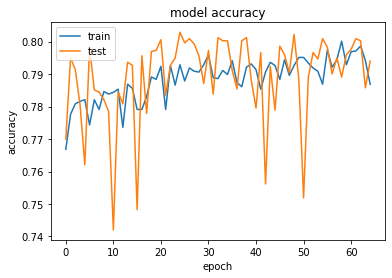

In [51]:
# according to documentation the model has to be refit
model2 = tuner.hypermodel.build(best_hp)
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32,
                        callbacks= tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                                patience=40,restore_best_weights=True),verbose=0)
plt.plot(history2.history['accuracy']) 
plt.plot(history2.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()


In [52]:
yprednn1=model2.predict(X_test)
yprednn1=yprednn1.round()
print('Neural Network:\n {}\n'.format(
    metrics.classification_report(yprednn1, y_test)))
nn_conf_matrix1=metrics.confusion_matrix(yprednn1,y_test)
conf_mat_nn1 = pd.DataFrame(
    nn_conf_matrix1, 
    columns=["Predicted NO", "Predicted YES"], 
    index=["Actual NO", "Actual YES"]
)
print(conf_mat_nn1)

Neural Network:
               precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      2362
         1.0       0.55      0.66      0.60       677

    accuracy                           0.80      3039
   macro avg       0.72      0.75      0.73      3039
weighted avg       0.82      0.80      0.81      3039


            Predicted NO  Predicted YES
Actual NO           1995            367
Actual YES           232            445


Thus, hypertuning does not result in better performance. In fact it gives a much complex model. Hypertuning may not be useful for small datasets to the extent.
However, in the Keras documentation under section of overfit and underfit, it is concluded that accuracy improves as capacity of the neural network is 'small'. Thus, as this is a similarly sized dataset, we can also use a network of 3 hidden layers with 64 to 128 hidden units at most.

Testing different batch sizes : It results in slightly lower performances with both lesser and greater sizes than 32. 

Thus this code block may be skipped.

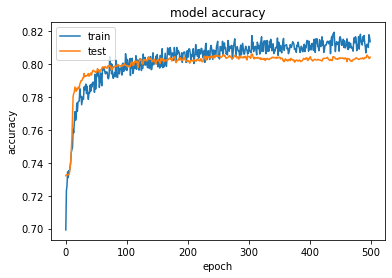

In [54]:
# Model 3 


model = Sequential()
model.add(Dense(64,kernel_regularizer=tf.keras.regularizers.l2(0.001),
                input_dim=46, activation='relu' ))
model.add(Dropout(rate=0.35))
model.add(Dense(8,kernel_regularizer=tf.keras.regularizers.l2(0.001),
                    activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001,
      decay_steps=(X_train.shape[0]/1024)*100,
      decay_rate=1,
      staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)
def get_callbacks():
    return [tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=150,
        restore_best_weights=True)]
model.compile(loss = "binary_crossentropy", 
                  optimizer = get_optimizer(), 
                  metrics=['accuracy'])
    

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=1024,
                    callbacks= get_callbacks(),verbose=0)

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

The effect of greater batch size can be observed from this learning curves.

In [55]:
yprednn=model.predict(X_test)
yprednn=yprednn.round()
print('Neural Network:\n {}\n'.format(
    metrics.classification_report(yprednn, y_test)))
print('Neural Network:\n {}\n'.format(
    metrics.confusion_matrix(yprednn, y_test)))

Neural Network:
               precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      2380
         1.0       0.54      0.66      0.60       659

    accuracy                           0.80      3039
   macro avg       0.72      0.75      0.73      3039
weighted avg       0.82      0.80      0.81      3039


Neural Network:
 [[2006  374]
 [ 221  438]]



# 3. Performance of the models
### Confusion Matrix, ROC Curve and Precision Recall Curves

The confusion matrix and ROC curve give the sense of true positive negative accuracy,however it is precision-recall curve that gives sense of accuracy in imbalanced dataset. In this dataset there are more negative instances than positive and thus Precision-Recall curve shows real performance. 

The ROC can be overly optimistic as it will be more if model predicts negative instances properly but fails on positive instances.

### 1. Random Forest performance

In [56]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

            Predicted NO  Predicted YES
Actual NO      70.036974       3.384528
Actual YES      6.143345      20.435154


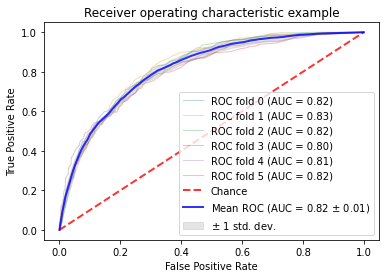

In [57]:
rf_conf_matrix  = metrics.confusion_matrix(y, stratified_cv(X, y, ensemble.RandomForestClassifier,n_estimators=113))
conf_mat_rf = pd.DataFrame(
    rf_conf_matrix, 
    columns=["Predicted NO", "Predicted YES"], 
    index=["Actual NO", "Actual YES"]
)
print((conf_mat_rf/7032)*100)
cv=StratifiedKFold(n_splits=6)
classifier=RandomForestClassifier(n_estimators=113)
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
tprs=[]
aucs=[]
mean_fpr=np.linspace(0,1,100)
fig,ax=plt.subplots()
for i,(train,test) in enumerate(cv.split(X,y)):
    classifier.fit(X.iloc[train],y.iloc[train])
    viz=plot_roc_curve(classifier,X.iloc[test],y.iloc[test],name='ROC fold {}'.format(i),alpha=0.3,lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()


RF: f1=0.543 auc=0.603


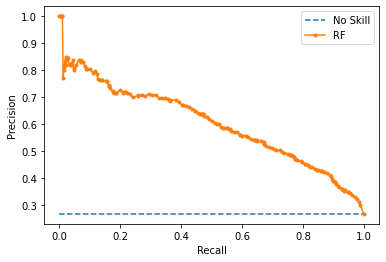

In [60]:
rfmodel=RandomForestClassifier(n_estimators= 130, max_features= 6,n_jobs=-1)
rfmodel.fit(X_train,y_train)
lg_probs = rfmodel.predict_proba(X_test)
lg_probs=lg_probs[:,1]
yhat = rfmodel.predict(X_test)

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lg_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('RF: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='RF')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### 2. XGBoost performance

            Predicted NO  Predicted YES
Actual NO      68.742890       4.678612
Actual YES      6.797497      19.781001


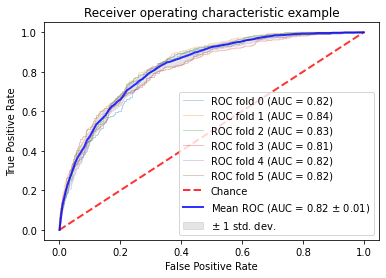

In [61]:
rf_conf_matrix  = metrics.confusion_matrix(y, stratified_cv(X, y, XGBClassifier))
conf_mat_XG = pd.DataFrame(
    rf_conf_matrix, 
    columns=["Predicted NO", "Predicted YES"], 
    index=["Actual NO", "Actual YES"]
)
print((conf_mat_XG/7032)*100)
cv=StratifiedKFold(n_splits=6)
classifier=XGBClassifier()
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
tprs=[]
aucs=[]
mean_fpr=np.linspace(0,1,100)
fig,ax=plt.subplots()
for i,(train,test) in enumerate(cv.split(X,y)):
    classifier.fit(X.iloc[train],y.iloc[train])
    viz=plot_roc_curve(classifier,X.iloc[test],y.iloc[test],name='ROC fold {}'.format(i),alpha=0.3,lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()


XGB: f1=0.543 auc=0.619


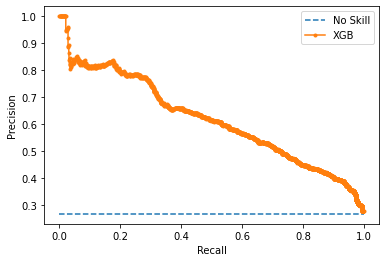

In [62]:
rfmodel=XGBClassifier(n_jobs=-1)
rfmodel.fit(X_train,y_train)
lg_probs = rfmodel.predict_proba(X_test)
lg_probs=lg_probs[:,1]
yhat1 = rfmodel.predict(X_test)

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lg_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('XGB: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='XGB')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### 3. Logistic Regression Performance

            Predicted NO  Predicted YES
Actual NO      65.799204       7.622298
Actual YES     12.044937      14.533561


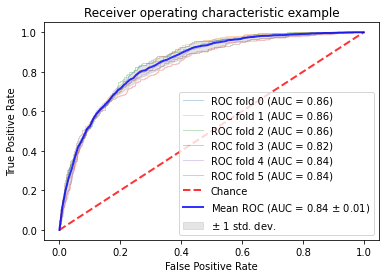

In [63]:
from sklearn.linear_model import LogisticRegression
rf_conf_matrix  = metrics.confusion_matrix(y, stratified_cv(X, y, LogisticRegression))
conf_mat_logis = pd.DataFrame(
    rf_conf_matrix, 
    columns=["Predicted NO", "Predicted YES"], 
    index=["Actual NO", "Actual YES"]
)
print((conf_mat_logis/7032) *100)
cv=StratifiedKFold(n_splits=6)
classifier=LogisticRegression()
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
tprs=[]
aucs=[]
mean_fpr=np.linspace(0,1,100)
fig,ax=plt.subplots()
for i,(train,test) in enumerate(cv.split(X,y)):
    classifier.fit(X.iloc[train],y.iloc[train])
    viz=plot_roc_curve(classifier,X.iloc[test],y.iloc[test],name='ROC fold {}'.format(i),alpha=0.3,lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()


Logistic: f1=0.543 auc=0.640


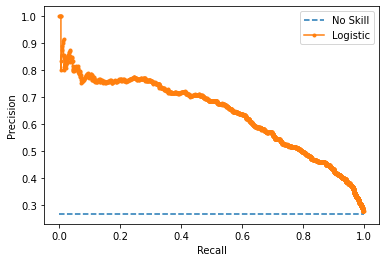

In [64]:
lgmodel=LogisticRegression(C= 784.75,penalty='l2',solver='liblinear',n_jobs=-1)
lgmodel.fit(X_train,y_train)
lg_probs = lgmodel.predict_proba(X_test)
lg_probs=lg_probs[:,1]
yhat1 = lgmodel.predict(X_test)

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lg_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Thus, ROC Curve shows that Logistic Regression generalizes better for this particular problem. 

### 4. Neural Networks performance

            Predicted NO  Predicted YES
Actual NO      67.193156      13.195130
Actual YES      6.087529      13.524186
No Skill: ROC AUC=0.500
Neural Network: ROC AUC=0.832


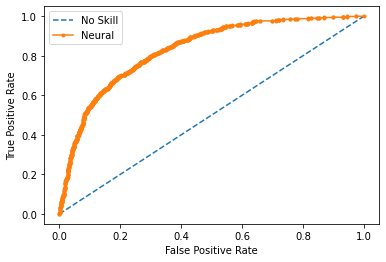

In [65]:

print((conf_mat_nn/3039)*100) #As computed in Neural Networks with Keras section above,here as a percentage

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = nn_model.predict(X_test)

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Neural Network: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Neural')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

            Predicted NO  Predicted YES
Actual NO      67.193156      13.195130
Actual YES      6.087529      13.524186
Neural Network: f1=0.584 auc=0.628


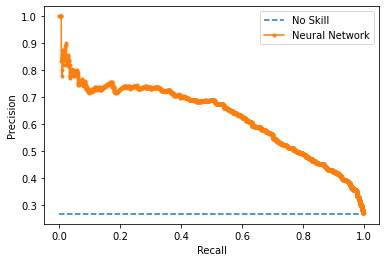

In [66]:

print((conf_mat_nn/3039)*100) #As computed in Neural Networks with Keras section above,here as a percentage

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = nn_model.predict(X_test)

yhat = nn_model.predict(X_test)
yhat=yhat.round()
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Neural Network: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Neural Network')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Observation
Thus, we can see that Random Forest and XGBoost are most accurate models, the Logistic Regression generalizes best and predicts both classes, churn and no churn, equally accurately. 

Thus it is Logistic Regression that will predict better if more positive instances, churn labels, are present in unseen data.

# 4. Feature importance and Conclusion

### 1)Feature importance according to Logistic Regression.

AxesSubplot(0.125,0.125;0.775x0.755)


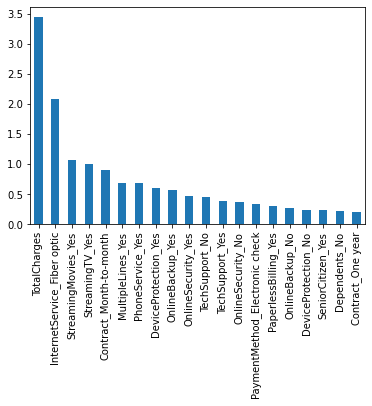

In [67]:
weights = pd.Series(lgmodel.coef_[0],
                 index=X.columns.values)
print (weights.sort_values(ascending = False)[:20].plot(kind='bar'))

AxesSubplot(0.125,0.125;0.775x0.755)


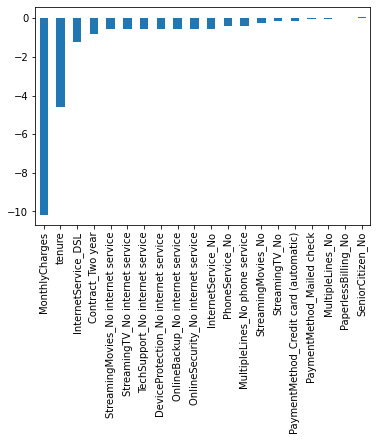

In [68]:
print (weights.sort_values(ascending = True)[:20].plot(kind='bar'))

### 2) Feature importance according to Random Forest

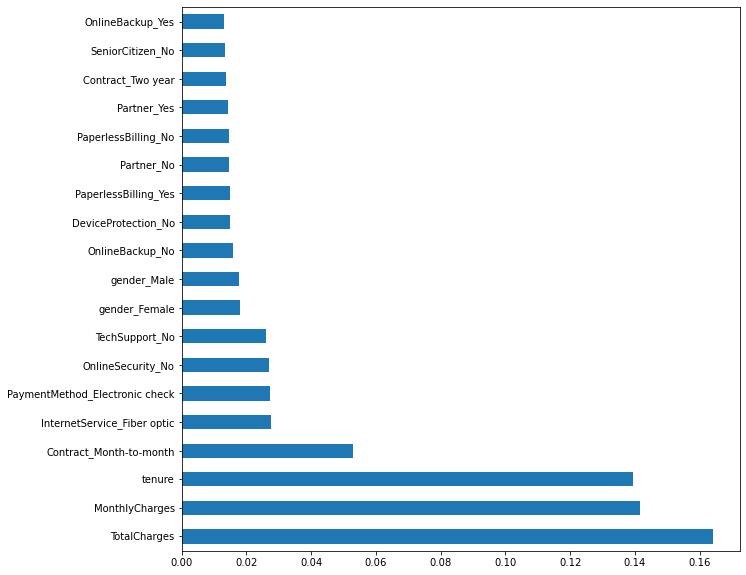

In [69]:
rf =  ensemble.RandomForestClassifier(n_estimators=130,max_features=6, n_jobs=-1)
rf.fit(X, y)
feature_importance = rf.feature_importances_
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(19)
feat_importances.plot(kind='barh' , figsize=(10,10)) 

### 3) Neural Network Feature Importance

As Keras does not provide a feature importance feature in the documentation i have demonstrated two ways of doing it. Reference is a Stack Over Flow answer.

In [70]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

def base_model():
    nn_model = Sequential()
    nn_model.add(Dense(64,kernel_regularizer=tf.keras.regularizers.l2(0.001),
                input_dim=46, activation='relu' ))
    nn_model.add(Dropout(rate=0.2))
    nn_model.add(Dense(8,kernel_regularizer=tf.keras.regularizers.l2(0.001),
                    activation='relu'))
    nn_model.add(Dropout(rate=0.1))
    nn_model.add(Dense(1, activation='sigmoid'))
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                  0.001,
                  decay_steps=(X_train.shape[0]/32)*50,
                  decay_rate=1,
                  staircase=False)

    def get_optimizer():
        return tf.keras.optimizers.Adam(lr_schedule)
    def get_callbacks():
        return [
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=70,restore_best_weights=True)]
    nn_model.compile(loss = "binary_crossentropy", 
                  optimizer = get_optimizer(), 
                  metrics=['accuracy'])
    return nn_model


my_model = KerasRegressor(build_fn=base_model)    
my_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32,
                    callbacks= get_callbacks(),verbose=0)

perm = PermutationImportance(my_model, random_state=1).fit(X[:500].values,y[:500].values,verbose=False)
eli5.show_weights(perm, feature_names = X.columns.tolist())

16/16 [==============================] - ETA: 0s - loss: 0.4372 - accuracy: 0.78 - 0s 3ms/step - loss: 0.3905 - accuracy: 0.8340


16/16 [==============================] - ETA: 0s - loss: 0.4175 - accuracy: 0.71 - 0s 2ms/step - loss: 0.3847 - accuracy: 0.8360


16/16 [==============================] - ETA: 0s - loss: 0.4033 - accuracy: 0.81 - 0s 2ms/step - loss: 0.3916 - accuracy: 0.8360


16/16 [==============================] - ETA: 0s - loss: 0.4153 - accuracy: 0.75 - ETA: 0s - loss: 0.3876 - accuracy: 0.82 - 0s 4ms/step - loss: 0.3903 - accuracy: 0.8280


Weight,Feature
0.0831 ± 0.0140,tenure
0.0361 ± 0.0129,Contract_Month-to-month
0.0174 ± 0.0097,Contract_Two year
0.0121 ± 0.0092,InternetService_DSL
0.0115 ± 0.0057,TechSupport_No
0.0086 ± 0.0064,OnlineSecurity_No
0.0084 ± 0.0071,InternetService_Fiber optic
0.0077 ± 0.0040,TechSupport_Yes
0.0071 ± 0.0029,TotalCharges
0.0066 ± 0.0078,PaymentMethod_Electronic check


In [72]:
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0831 ± 0.0140,tenure
0.0361 ± 0.0129,Contract_Month-to-month
0.0174 ± 0.0097,Contract_Two year
0.0121 ± 0.0092,InternetService_DSL
0.0115 ± 0.0057,TechSupport_No
0.0086 ± 0.0064,OnlineSecurity_No
0.0084 ± 0.0071,InternetService_Fiber optic
0.0077 ± 0.0040,TechSupport_Yes
0.0071 ± 0.0029,TotalCharges
0.0066 ± 0.0078,PaymentMethod_Electronic check


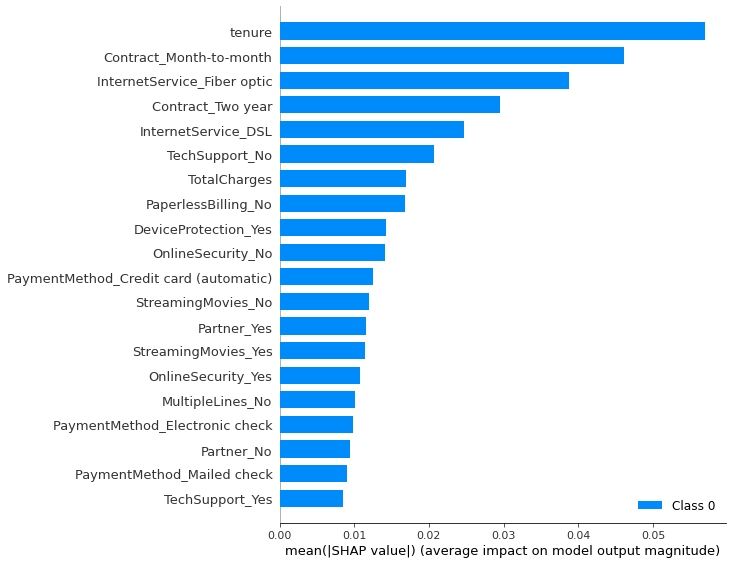

In [71]:
import shap
from tensorflow.keras import Sequential
# load your data here, e.g. X and y
# create and fit your model here

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.DeepExplainer(nn_model,data=X[:500].values)
shap_values = explainer.shap_values(X.values)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

shap.summary_plot(shap_values, X, plot_type="bar")

# Conclusion
1. It can be seen Total charges is the most important feature and rightfully so. The number one reason customers will 'churn' if they find the service to be expensive or unaffordable. 
2. Tenure is also important, the customers who have been using the sevice for a long time or have long time contracts, which are cheaper in general, are less likely to churn. It is interesting to observe that Tenure is listed as more important for neural network model. 
3. As observed in the EDA, most customers who are on month to month contracts are more likely to churn. Itcan be hypothesized that the reason is to be attributed to personal reasons of customers to have reservations about long term contracts or higher costs per unit time resulting from monthly contracts.
4. As seen in EDA, other important features are online security, electronic payment method, fiber optic internet service, tech support.
5. The features which are not important are gender, dependents, partner, streaming TV, backup and device protection.

Offers and improving churn rate:
1. Discounts: As the most important feature is total charges, followed by monthly charges, potential churners identified through the modelling should be offered huge discount on next month or months contract. This covers 80 % of the reasons identified for churning. For this modelling, the False Negative Rate should be minimised or Recall should be maximised so that the discounts are sent to maximum of the potential churners.
2. New contract: A six month or four month contract should be implemented. This will encourage the reserved customers who want shorter contracts and will increase their tenure on the service thus making them less likely to churn.
3. Online Security: This service should be promoted more and offered complimentary/free for trial periods depending on cost to company. The customers who do not have online security are more likely to churn and thus this offer could be combined with the first one mentioned and discount could only be offered on this.
4. Fiber optic: The fiber optic internet is costly and thus should either be promoted to appropriate target audience or better technology can be implemented to cut cost on this service. Ultimately the market research team has to decide the break even point for this service, whether it is profiting as much as the loss of customers it is causing.
5. Select services discounting: In addition to offering disounts on next month contract, discounts can be offered on important services to potential churners. These services include discount on online security, tech support, DSL internet, electronic checks and potentially streaming movies. 

After these actions are implemented the modelling using newer data needs to performed and analyze the improvements. Another method to quantify the offers to be made is using manually generated features and their effect on the model.

# References
1. Random Forest vs Neural Networks for Predicting Customer Churn, Abhinav Sagar, Medium,https://towardsdatascience.com/random-forest-vs-neural-networks-for-predicting-customer-churn-691666c7431e

2. Using basic neural networks to predict churn, Laurier Mantel, https://www.kaggle.com/lauriermantel/using-basic-neural-networks-to-predict-churn

3. How to Use ROC Curves and Precision-Recall Curves for Classification in Python, Jason Brownlee, https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

4. Tensorflow, Keras,sklearn documentation

5. Feature importance of Neural Network,StackOverFlow, https://stackoverflow.com/questions/45361559/feature-importance-chart-in-neural-network-using-keras-in-python#:~:text=It%20most%20easily%20works%20with,using%20it%20is%20very%20straightforward.&text=At%20the%20moment%20Keras%20doesn,to%20extract%20the%20feature%20importance.